<a href="https://colab.research.google.com/github/hprasad99/Deep-Learning/blob/master/CamVid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = untar_data(URLs.CAMVID)

In [4]:
path.ls()

[PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/codes.txt')]

In [5]:
path_lbl = path/'labels'
path_img = path/'images'

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0016E5_08149.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_007410.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_007680.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0016E5_06390_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0001TP_008850_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f04230_P.png')]

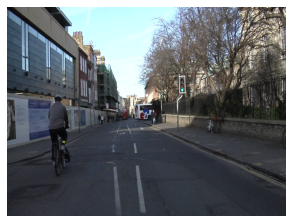

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [9]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

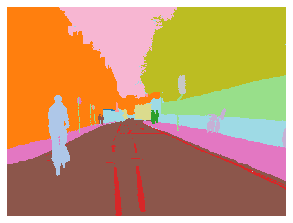

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5),alpha=1)

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [12]:
codes = np.loadtxt(path/'codes.txt',dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [13]:
size = src_size//2

free =gpu_mem_get_free_no_cache()
if free>8200:
  bs = 8
else:
  bs = 4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 15068MB of GPU RAM free


In [14]:
src = (SegmentationItemList.from_folder(path_img).split_by_fname_file('../valid.txt').label_from_func(get_y_fn,classes=codes))

In [15]:
data = (src.transform(get_transforms(),size=size, tfm_y=True).databunch(bs=bs).normalize(imagenet_stats))

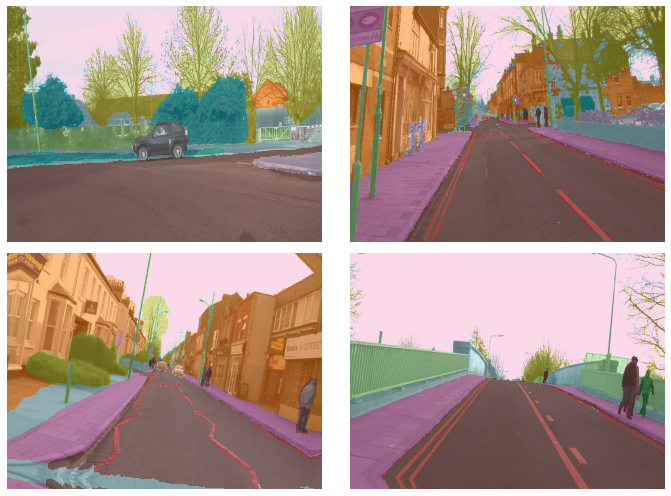

In [16]:
data.show_batch(2,figsize=(10,7))

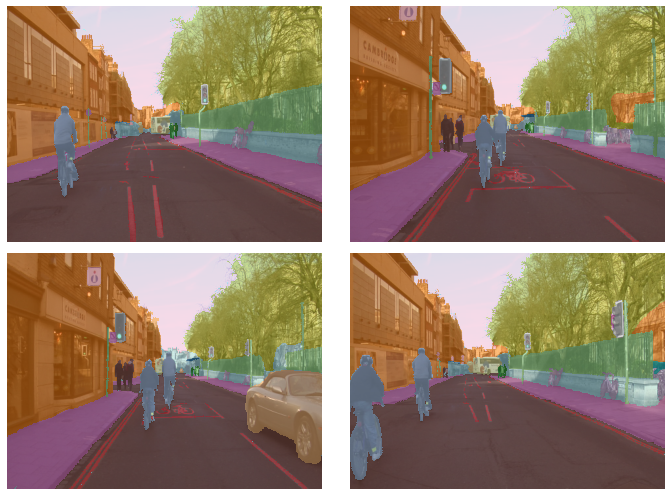

In [17]:
data.show_batch(2,figsize=(10,7),ds_type=DatasetType.Valid)

In [18]:
name2id  = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input,target):
  target=target.squeeze(1)
  mask = target != void_code
  return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [19]:
metrics = acc_camvid

In [20]:
wd=1e-2

In [21]:
learn = unet_learner(data,models.resnet34,metrics=metrics,wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


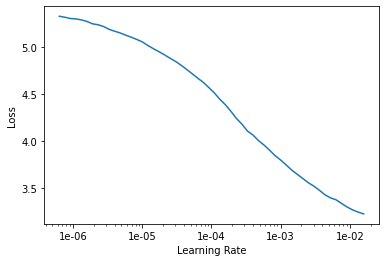

In [22]:
lr_find(learn)
learn.recorder.plot()

In [23]:
lr = 3e-3

In [24]:
learn.fit_one_cycle(10,slice(lr),pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.311144,0.838190,0.793769,01:29
1,0.863254,0.677258,0.824071,01:26
2,0.731751,0.566542,0.848656,01:26
3,0.708006,0.710430,0.845349,01:26
4,0.647451,0.571263,0.857485,01:25
5,0.605188,0.510241,0.861427,01:25
6,0.572285,0.532150,0.865828,01:25
7,0.559842,0.448426,0.882598,01:25
8,0.528876,0.415459,0.873987,01:25
9,0.453698,0.357926,0.895492,01:24


In [25]:
learn.save('stage-1')

In [26]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

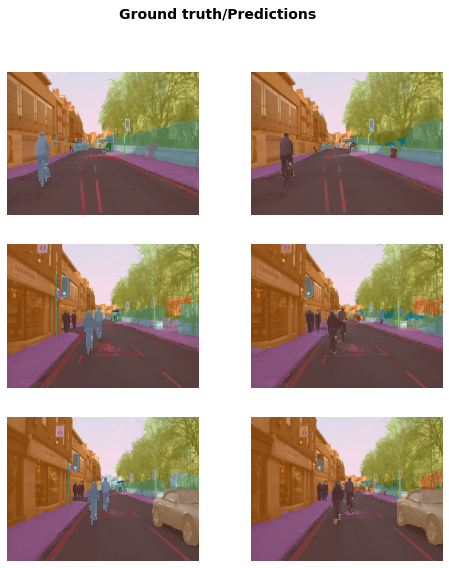

In [27]:
learn.show_results(rows=3,figsize=(8,9))

In [28]:
learn.unfreeze()

In [29]:
lrs = slice(lr/400,lr/4)

In [30]:
learn.fit_one_cycle(12,lrs,pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.395877,0.341839,0.900747,01:28
1,0.381337,0.323511,0.905615,01:28
2,0.373773,0.327453,0.903409,01:28
3,0.358982,0.307768,0.914795,01:29
4,0.347711,0.321750,0.906542,01:28
5,0.338492,0.316060,0.908606,01:28
6,0.325560,0.304530,0.910493,01:29
7,0.320170,0.274089,0.923685,01:29
8,0.309161,0.317876,0.912431,01:29
9,0.306624,0.284557,0.918543,01:29


In [31]:
learn.save('stage-2')

In [32]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs =3
else:           bs =1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=3, have 14285MB of GPU RAM free


In [33]:
data = (src.transform(get_transforms(), size=size,tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [34]:
learn = unet_learner(data,models.resnet34,metrics=metrics,wd=wd)

In [35]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


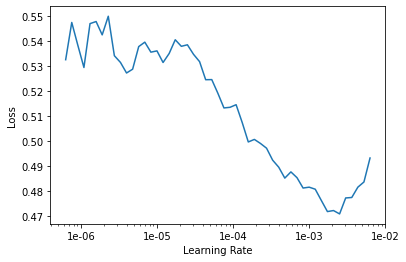

In [36]:
lr_find(learn)
learn.recorder.plot()

In [37]:
lr = 1e-3

In [38]:
learn.fit_one_cycle(10,slice(lr),pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.385442,0.308711,0.915248,05:56
1,0.334186,0.298290,0.917840,05:53
2,0.318056,0.368984,0.906760,05:53
3,0.332046,0.309294,0.927030,05:52
4,0.333600,0.282866,0.920558,05:52
5,0.330027,0.351971,0.897632,05:52
6,0.317010,0.304583,0.917227,05:51
7,0.327613,0.308848,0.912799,05:50
8,0.279671,0.293947,0.924466,05:50
9,0.229136,0.235526,0.935550,05:50


In [39]:
learn.save('stage-1-big')

In [40]:
learn.load('stage-1-big')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

In [41]:
lrs = slice(1e-6,lr/10)

In [42]:
learn.fit_one_cycle(10,lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.216509,0.233230,0.936154,05:50
1,0.214319,0.239588,0.935431,05:50
2,0.208647,0.236875,0.937455,05:51
3,0.227478,0.230126,0.935141,05:51
4,0.208853,0.234187,0.936026,05:51
5,0.207730,0.239993,0.935775,05:51
6,0.191405,0.236463,0.937640,05:52
7,0.199139,0.238622,0.937424,05:52
8,0.191865,0.236109,0.937207,05:51
9,0.192097,0.237047,0.937162,05:52


In [43]:
learn.save('stage-2-big')

In [44]:
learn.load('stage-2-big')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

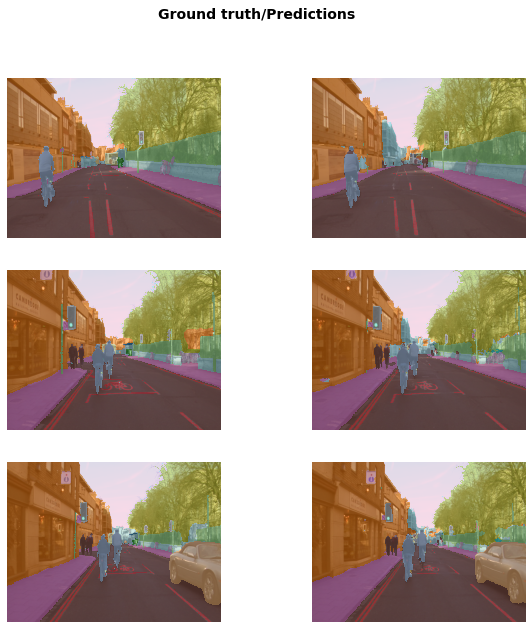

In [45]:
learn.show_results(rows=3,figsize=(10,10))